In [1]:
train = pd.read_hdf("../input/hdfs-dataset/train.hd5")
test = pd.read_hdf("../input/hdfs-dataset/test.hd5")


In [2]:
from keras.models import load_model

encoder = load_model("encoder_v3.hd5")
decoder = load_model("decoder_v3.hd5")


/home/musella/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/musella/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
encoded_train = encoder.predict(train)
encoded_test = encoder.predict(test)

In [4]:
train_slices = np.vstack( [ train.iloc[pos-30:pos].values.reshape(1,30,-1) for pos in range(30,train.index.shape[0]) ] )
test_slices = np.vstack( [ test.iloc[pos-30:pos].values.reshape(1,30,-1) for pos in range(30,test.index.shape[0]) ] )


In [5]:
train_slices.shape

(1556, 30, 55)

In [6]:
encoded_train.shape

(1586, 8)

In [7]:
test_slices.shape

(707, 30, 55)

In [8]:
encoded_test.shape

(737, 8)

In [9]:
from keras.layers import TimeDistributed, GRU, Input, Dense, Conv1D, Concatenate
from keras.models import Model

In [10]:
inp = Input(train_slices.shape[1:])

inp2 = Input(train.shape[1:])


L = Conv1D(32,1,activation="relu")(inp)

L = GRU(8,return_sequences=False)(L)

L2 = encoder(inp2)

L = Concatenate()([L,L2])

L = Dense(8,activation="relu")(L)

L = decoder(L)


model = Model(inputs=[inp,inp2], outputs=L)


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 55)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 30, 32)       1792        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 55)           0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 8)            984         conv1d_1[0][0]                   
__________________________________________________________________________________________________
encoder (M

In [12]:
from keras.optimizers  import Adam

optimizer = Adam(lr=5e-4)
model.compile(optimizer=optimizer,loss="mse")


In [13]:
model.fit([train_slices[:-1],train.iloc[31:]],train.iloc[31:],epochs=100,validation_split=0.2)

Train on 1244 samples, validate on 311 samples
Epoch 1/100
1244/1244 [==============================] - 5s 4ms/step - loss: 0.5475 - val_loss: 1.0531
Epoch 2/100
1244/1244 [==============================] - 3s 3ms/step - loss: 0.5331 - val_loss: 1.0495
Epoch 3/100
1244/1244 [==============================] - 4s 3ms/step - loss: 0.5200 - val_loss: 1.0410
Epoch 4/100
1244/1244 [==============================] - 3s 2ms/step - loss: 0.5022 - val_loss: 1.0289
Epoch 5/100
1244/1244 [==============================] - 3s 2ms/step - loss: 0.4849 - val_loss: 1.0174
Epoch 6/100
1244/1244 [==============================] - 3s 3ms/step - loss: 0.4697 - val_loss: 1.0059
Epoch 7/100
1244/1244 [==============================] - 4s 3ms/step - loss: 0.4553 - val_loss: 0.9968
Epoch 8/100
1244/1244 [==============================] - 4s 3ms/step - loss: 0.4410 - val_loss: 0.9909
Epoch 9/100
1244/1244 [==============================] - 3s 3ms/step - loss: 0.4308 - val_loss: 0.9870
Epoch 10/100
1244/1244 [==

In [14]:
train_true = train.values[31:]
test_true = test.values[31:]

train_pred = model.predict([train_slices[:-1],train_true])
test_pred = model.predict([test_slices[:-1],test_true])

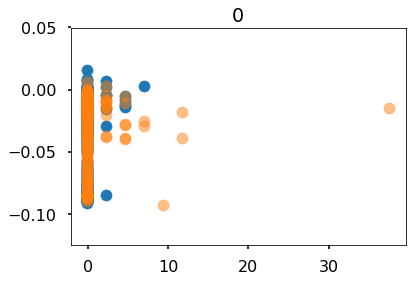

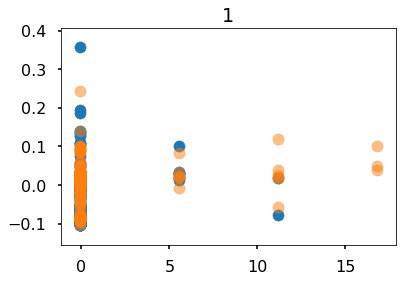

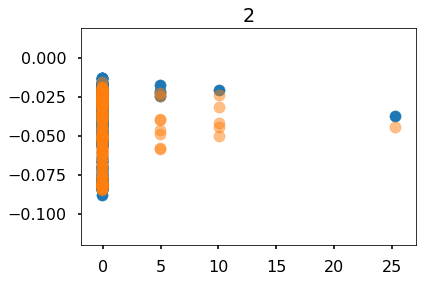

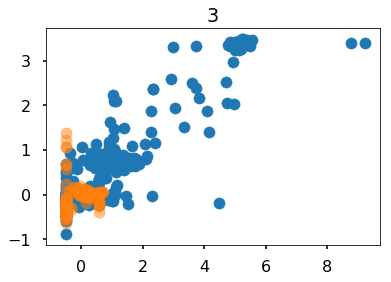

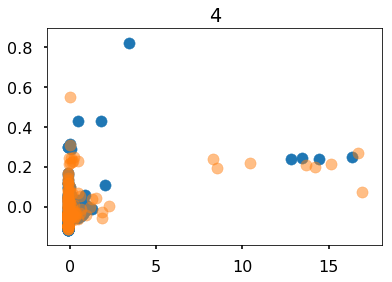

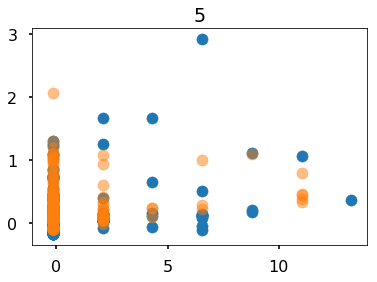

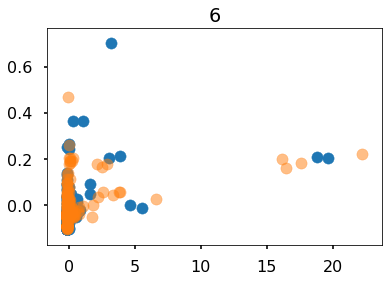

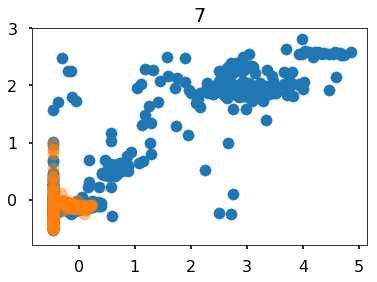

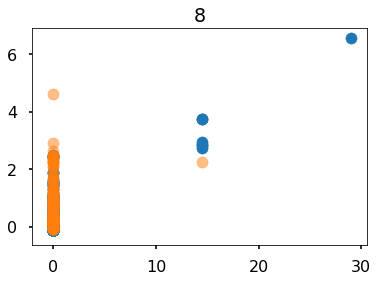

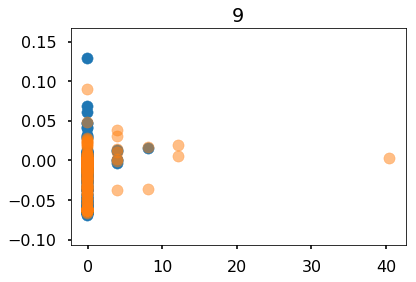

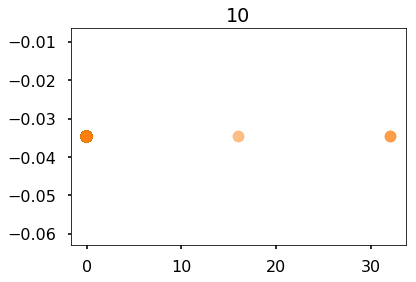

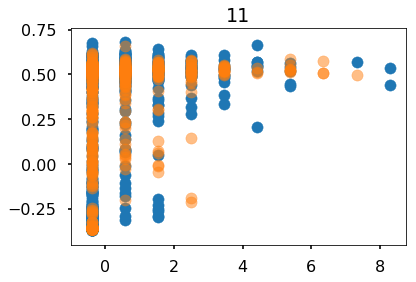

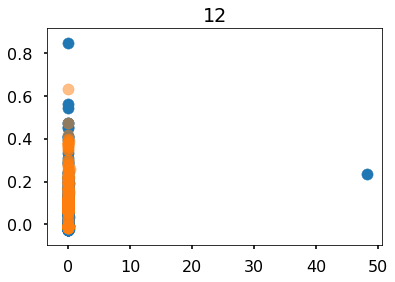

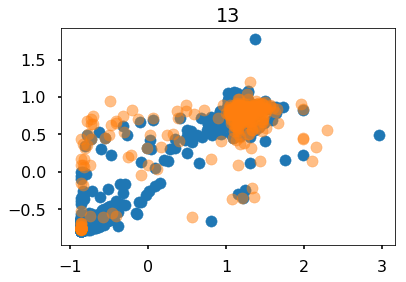

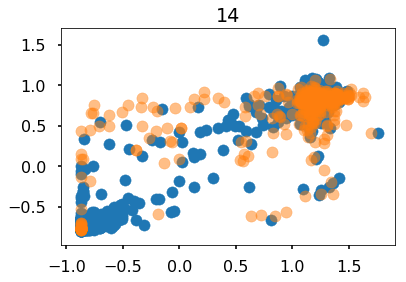

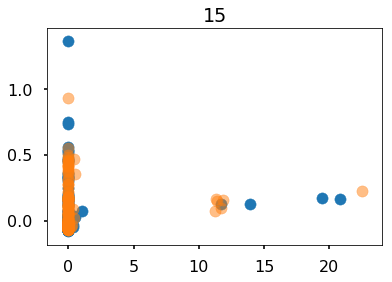

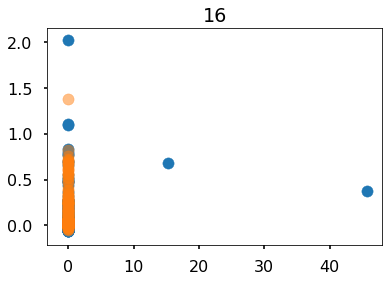

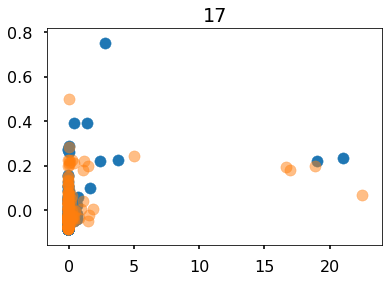

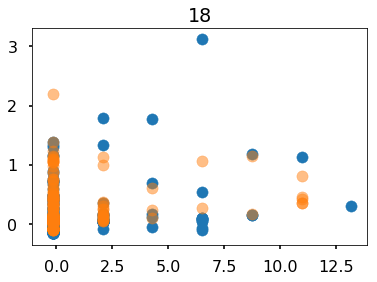

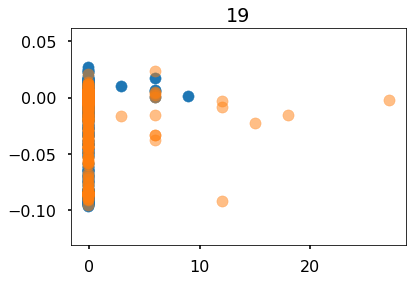

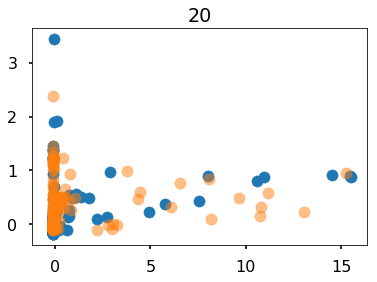

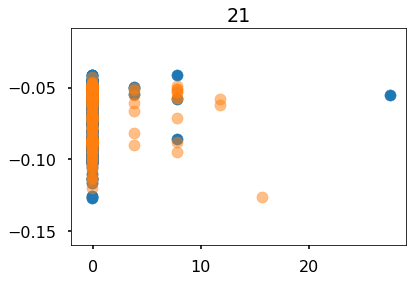

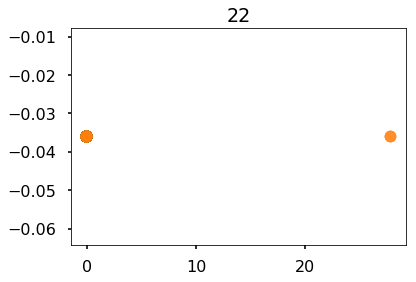

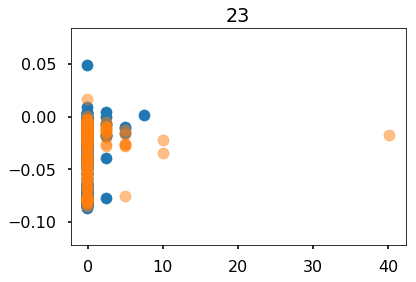

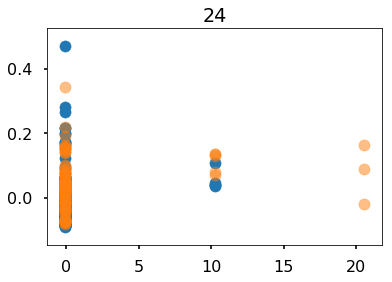

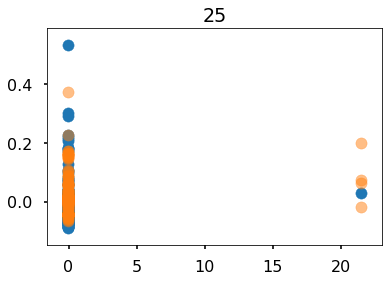

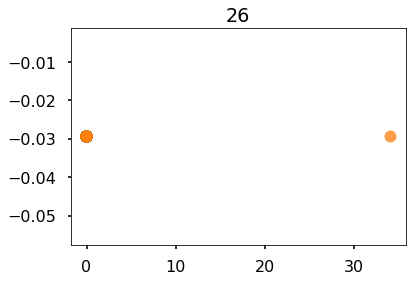

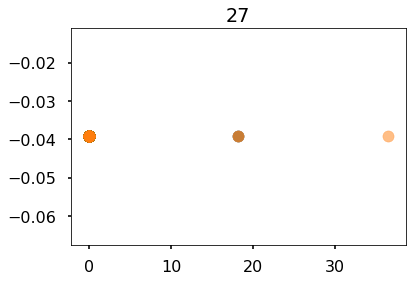

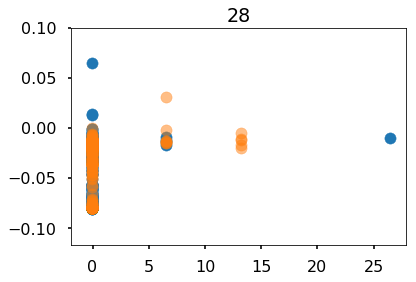

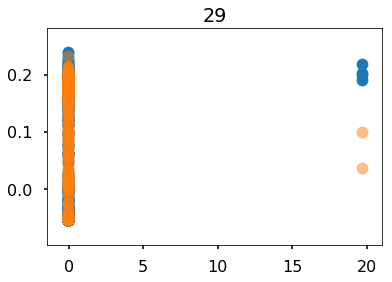

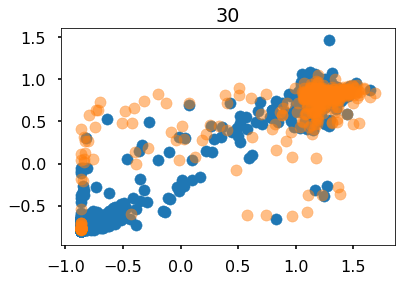

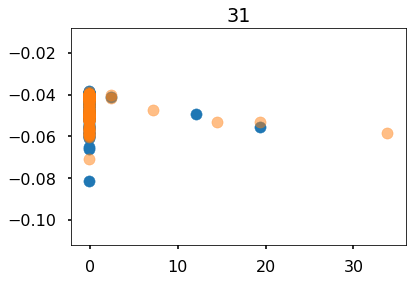

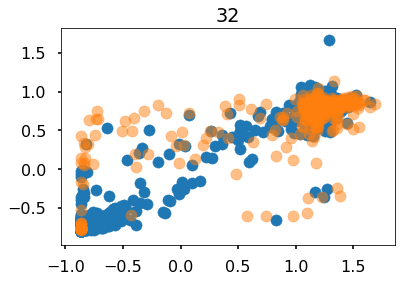

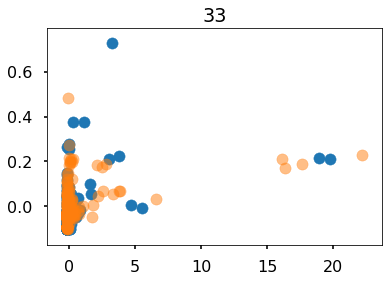

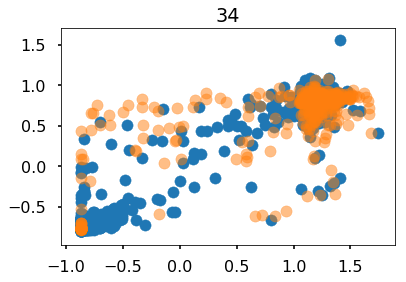

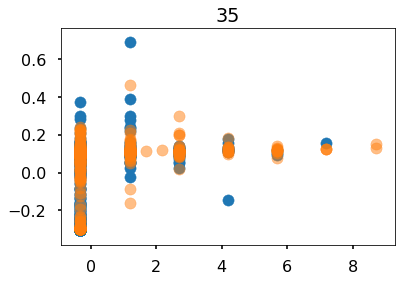

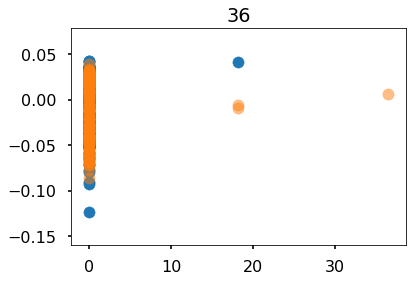

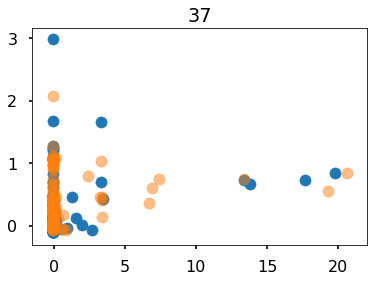

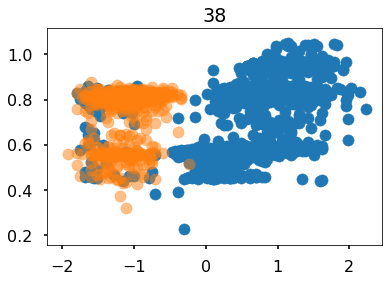

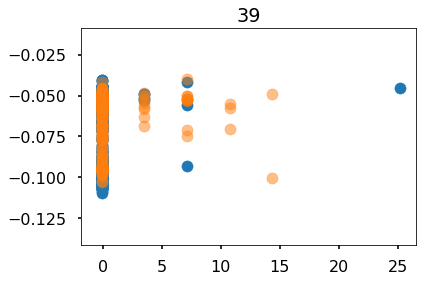

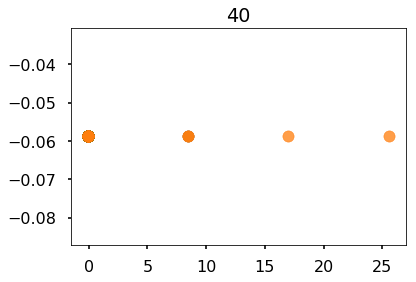

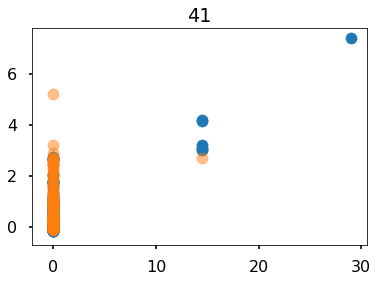

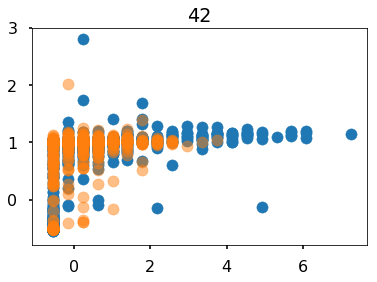

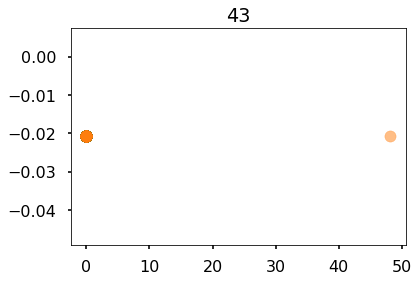

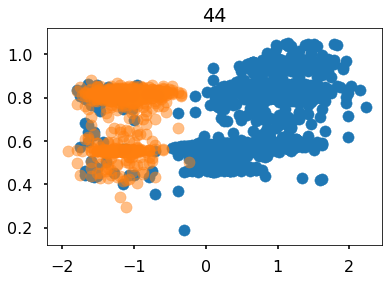

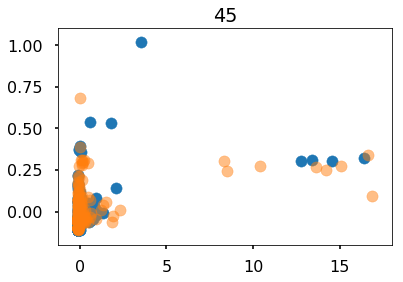

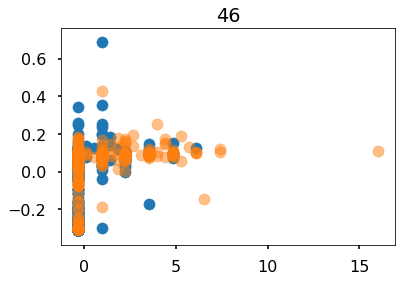

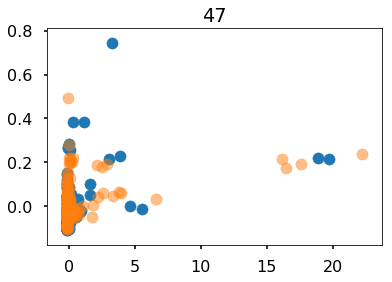

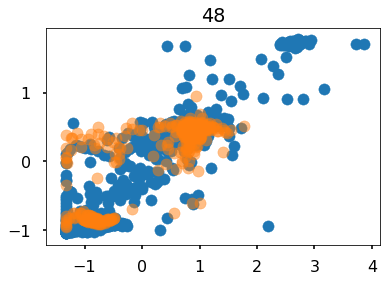

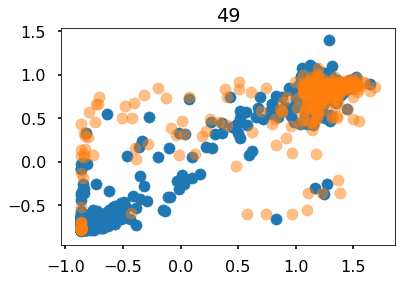

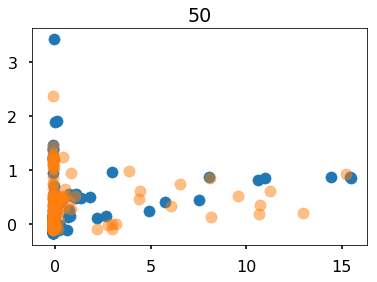

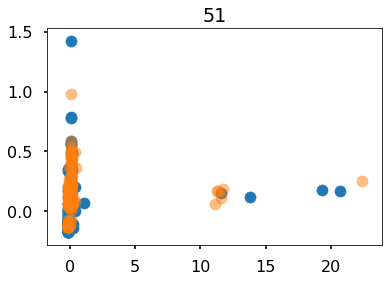

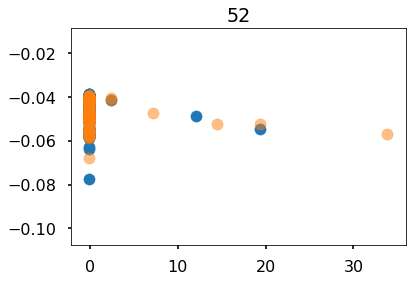

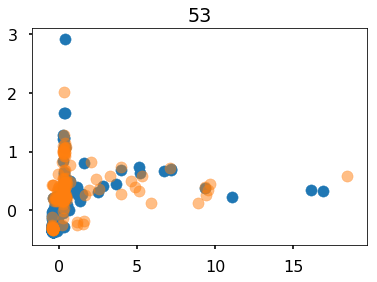

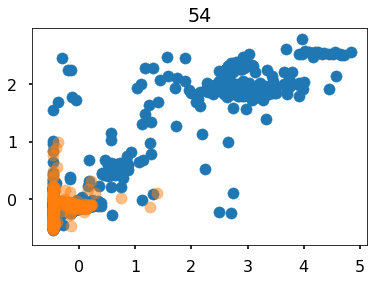

In [15]:
for col in range(55):
    plt.scatter(train_true[:,col],train_pred[:,col])
    plt.scatter(test_true[:,col],test_pred[:,col],alpha=0.5)
    plt.title(col)
    plt.show()

In [16]:
score_test = ((test_true-test_pred)**2).sum(axis=1)
score_train = ((train_true-train_pred)**2).sum(axis=1)

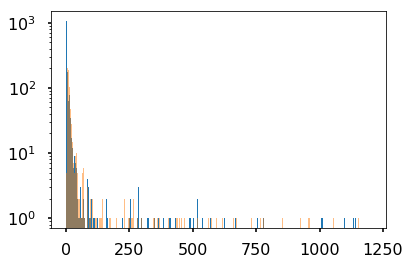

In [17]:
%matplotlib inline
plt.hist(score_train,bins=300,range=[0,1200]);
plt.hist(score_test,bins=300,range=[0,1200],alpha=0.5);
plt.yscale("log")

In [18]:
test_pred_autoenc = pd.read_hdf("../input/hdfs-dataset/test_pred_v3.hd5")

In [19]:
test_pred_autoenc["score_rnn"] = np.ones(test_pred_autoenc.shape[0])*np.nan
test_pred_autoenc["score_rnn"].iloc[31:] = score_test

/home/musella/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


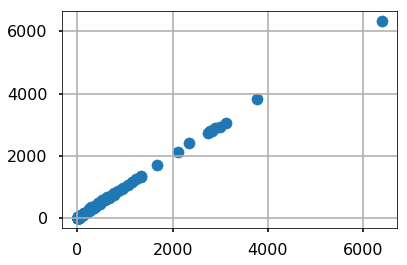

In [20]:
plt.scatter(test_pred_autoenc["score_rnn"].iloc[31:],test_pred_autoenc["score"].iloc[31:])#,bins=200,range=[[0,1200],[0,122]]);
plt.grid()

In [21]:
df_suspicious = test.iloc[31:][score_test>200]

susp_columns = test.columns[np.abs(test_pred-test_true)[score_test>200].argsort(axis=1)[:,-3:]]


In [22]:
suspicions = []
suspicions_index = []

for row, cols in zip(df_suspicious.iterrows(),susp_columns):
    suspicions_index.append(row[0])
    suspicions.append(" ".join(reversed(cols)))
    

In [23]:
df_suspicions = pd.DataFrame(index=suspicions_index,data=dict(suspicions_rnn=suspicions))

In [24]:
test = test_pred_autoenc.join(df_suspicions)

In [25]:
test.iloc[31:][["suspicions","suspicions_rnn"]].dropna()

,suspicions,suspicions_rnn
2008-11-11 02:30:00,Component_7 TemplateId_15 Level_0,TemplateId_15 Component_7 Level_0
2008-11-11 02:32:00,TemplateId_20 Component_6 Level_0,TemplateId_20 Component_6 Level_0
2008-11-11 03:32:00,TemplateId_28 TemplateId_2 TemplateId_39,TemplateId_28 TemplateId_2 TemplateId_39
2008-11-11 03:33:00,TemplateId_43 TemplateId_2 TemplateId_28,TemplateId_43 TemplateId_2 TemplateId_28
2008-11-11 03:34:00,TemplateId_39 TemplateId_28 TemplateId_23,TemplateId_39 TemplateId_28 TemplateId_23
2008-11-11 03:35:00,TemplateId_28 TemplateId_39 TemplateId_40,TemplateId_28 TemplateId_39 TemplateId_40
2008-11-11 03:36:00,TemplateId_0 TemplateId_23 TemplateId_40,TemplateId_0 TemplateId_23 TemplateId_40
2008-11-11 03:37:00,TemplateId_9 TemplateId_23 TemplateId_0,TemplateId_9 TemplateId_23 TemplateId_0
2008-11-11 03:38:00,TemplateId_5 TemplateId_18 TemplateId_37,TemplateId_5 TemplateId_18 TemplateId_41
2008-11-11 04:39:00,TemplateId_36 TemplateId_10 TemplateId_29,TemplateId_36 TemplateId_10 TemplateId_29


In [26]:
test.to_hdf("../input/hdfs-dataset/test_pred_rnn_v3.hd5","pred_rnn")

/home/musella/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['suspicions', 'suspicions_rnn']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
